# Generacion de EDA para la base de datos

Para la presentación del EDA para nuestra base de datos, utilizamos como ploteo nuestras primeras 3 muestras filtradas de la base de datos encontrada


--- Resumen de archivos cargados ---
sujeto_1: 1280000 muestras, columnas: ['ch1', 'ch2', 'ch3', 'ch4', 'sample', 'subject']
sujeto_2: 1280000 muestras, columnas: ['ch1', 'ch2', 'ch3', 'ch4', 'sample', 'subject']
sujeto_3: 1280000 muestras, columnas: ['ch1', 'ch2', 'ch3', 'ch4', 'sample', 'subject']


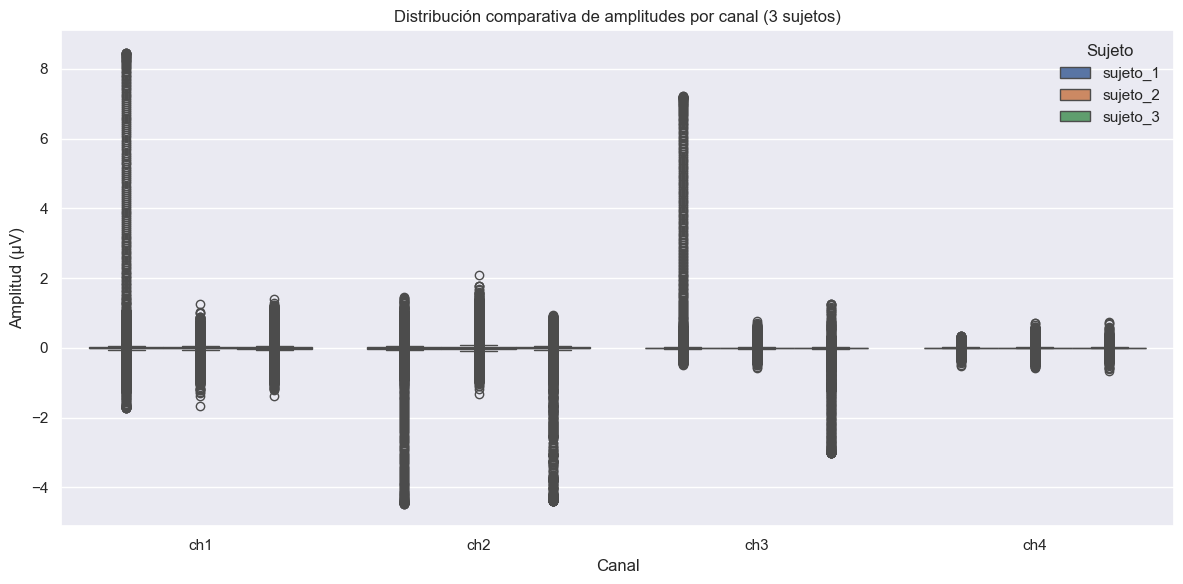

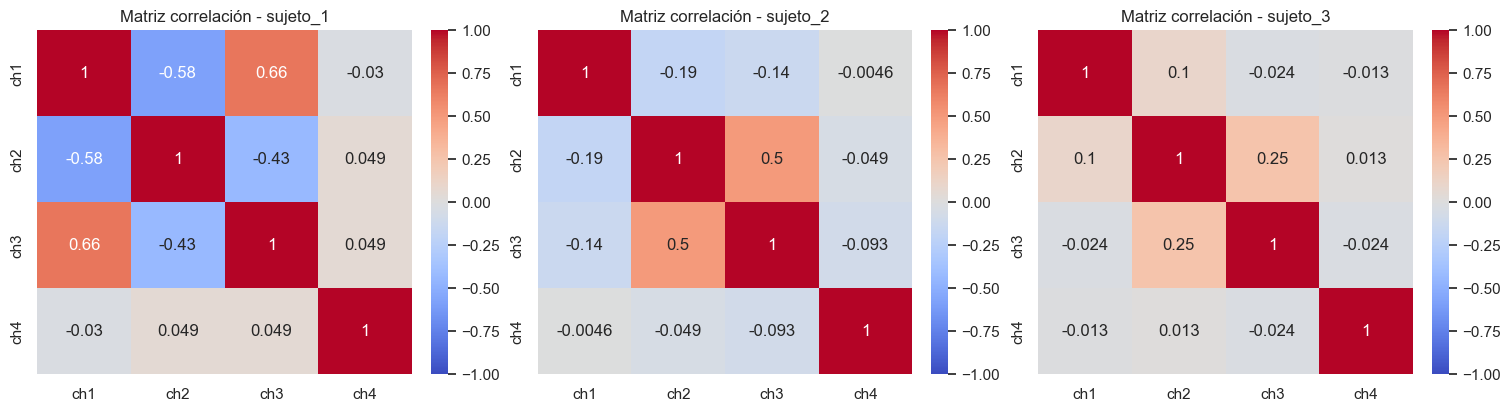

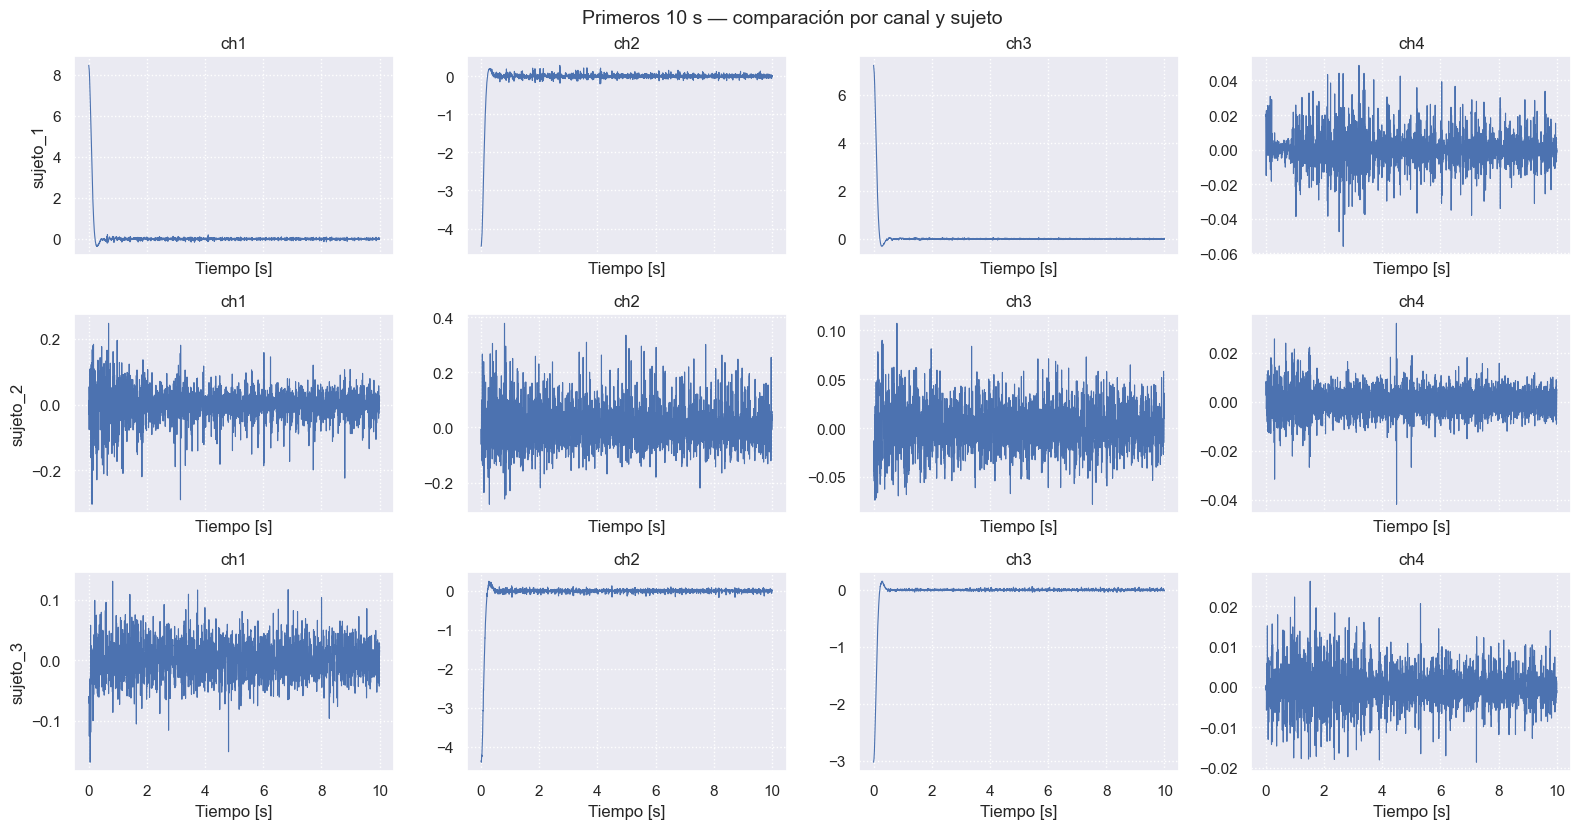

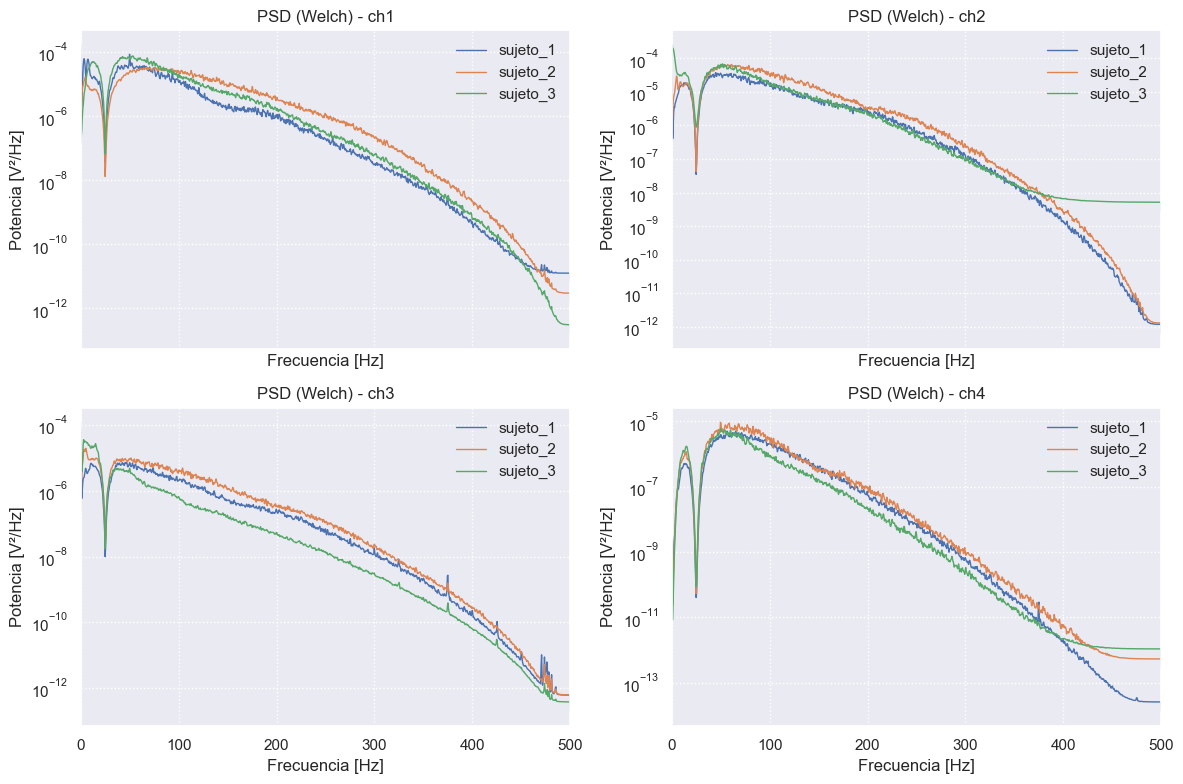


--- Estadísticas resumidas por sujeto ---


ch1                                              ch2            \
            count      mean       std       min       max    count      mean   
subject                                                                        
sujeto_1  1280000  0.000639  0.082504 -1.723411  8.456798  1280000 -0.000337   
sujeto_2  1280000  0.000001  0.056154 -1.665371  1.268372  1280000  0.000004   
sujeto_3  1280000 -0.000005  0.067619 -1.380209  1.396323  1280000 -0.000649   

                                            ch3                                \
               std       min       max    count      mean       std       min   
subject                                                                         
sujeto_1  0.062552 -4.466378  1.451840  1280000  0.000538  0.058581 -0.492958   
sujeto_2  0.072692 -1.330628  2.080420  1280000  0.000003  0.029225 -0.561904   
sujeto_3  0.078142 -4.391196  0.948394  1280000 -0.000226  0.033214 -3.022639   

                        ch4                                              
               max    count          mean       std       min       max  
subject                                                                  
sujeto_1  7.215951  1280000  1.480295e-06  0.016425 -0.505413  0.339045  
sujeto_2  0.775551  1280000 -8.673366e-08  0.020596 -0.569632  0.728236  
sujeto_3  1.273405  1280000  6.401171e-08  0.014986 -0.674516  0.754705

In [ ]:
# EDA para 3 señales sEMG filtradas — comparación entre sujetos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import welch
import os

# -------------------------------
# Configuración y rutas de archivos
# -------------------------------
fs = 1000  # Hz (frecuencia de muestreo asumida)
data_dir = "C:/Users/DAVID/Desktop/INTRO A SEÑALES/proyecto/ckwc76xr2z-2/sEMG-dataset/filtered/csv"
files = [
    os.path.join(data_dir, "1_filtered.csv"),
    os.path.join(data_dir, "2_filtered.csv"),
    os.path.join(data_dir, "3_filtered.csv"),
]
labels = ["sujeto_1", "sujeto_2", "sujeto_3"]  # etiquetas para comparación

# -------------------------------
# 1️⃣ CARGA DE LAS 3 SEÑALES
# -------------------------------
dfs = []
for fpath, lab in zip(files, labels):
    if not os.path.exists(fpath):
        print(f"Advertencia: no se encontró {fpath}. Se omite {lab}.")
        continue
    df_tmp = pd.read_csv(fpath, header=None)
    # asegurar 4 columnas y nombrarlas
    if df_tmp.shape[1] < 4:
        raise ValueError(f"Archivo {fpath} tiene menos de 4 columnas.")
    df_tmp = df_tmp.iloc[:, :4].copy()
    df_tmp.columns = ['ch1', 'ch2', 'ch3', 'ch4']
    df_tmp['sample'] = np.arange(len(df_tmp))
    df_tmp['subject'] = lab
    dfs.append(df_tmp)

if len(dfs) == 0:
    raise FileNotFoundError("No se cargó ningún archivo. Revisa las rutas.")

# Concatenar para análisis comparativo
df_all = pd.concat(dfs, ignore_index=True)

print("\n--- Resumen de archivos cargados ---")
for lab, d in zip(labels, dfs):
    print(f"{lab}: {d.shape[0]} muestras, columnas: {list(d.columns)}")

# -------------------------------
# 2️⃣ DISTRIBUCIÓN COMPARATIVA (boxplot / violin)
# -------------------------------
plt.style.use('seaborn-v0_8-darkgrid')
sns.set(font_scale=1.0)
plt.figure(figsize=(12, 6))

df_melt = df_all.melt(id_vars=['subject', 'sample'], value_vars=['ch1','ch2','ch3','ch4'],
                      var_name='Canal', value_name='Amplitud (µV)')

# Boxplot con hue por sujeto
sns.boxplot(data=df_melt, x='Canal', y='Amplitud (µV)', hue='subject')
plt.title('Distribución comparativa de amplitudes por canal (3 sujetos)')
plt.legend(title='Sujeto')
plt.tight_layout()
plt.show()

# -------------------------------
# 3️⃣ MATRICES DE CORRELACIÓN POR SUJETO
# -------------------------------
n = len(dfs)
fig, axes = plt.subplots(1, n, figsize=(5*n, 4), constrained_layout=True)
if n == 1:
    axes = [axes]
for ax, d in zip(axes, dfs):
    corr = d[['ch1','ch2','ch3','ch4']].corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, ax=ax)
    ax.set_title(f"Matriz correlación - {d['subject'].iloc[0]}")
plt.show()

# -------------------------------
# 4️⃣ VISUALIZACIÓN TEMPORAL (primeros 10 s) — panel comparativo
# -------------------------------
dur_sec = 10
dur_samples = min(int(dur_sec * fs), min([len(d) for d in dfs]))
fig, axes = plt.subplots(len(dfs), 4, figsize=(16, 3*len(dfs)), sharex=True)
for i, d in enumerate(dfs):
    t = np.arange(dur_samples) / fs
    for j, ch in enumerate(['ch1','ch2','ch3','ch4']):
        axes[i, j].plot(t, d[ch].values[:dur_samples], label=f"{d['subject'].iloc[0]}-{ch}", linewidth=0.8)
        axes[i, j].set_xlabel('Tiempo [s]')
        if j == 0:
            axes[i, j].set_ylabel(f"{d['subject'].iloc[0]}")
        axes[i, j].set_title(f"{ch}")
        axes[i, j].grid(True, ls=":")
plt.suptitle('Primeros 10 s — comparación por canal y sujeto', y=0.92, fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# -------------------------------
# 5️⃣ DENSIDAD ESPECTRAL DE POTENCIA (Welch) — comparar por canal
# -------------------------------
nperseg = min(2048, min([len(d) for d in dfs]))
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)
axes = axes.flatten()
for idx, ch in enumerate(['ch1','ch2','ch3','ch4']):
    ax = axes[idx]
    for d in dfs:
        sig = d[ch].values
        if sig.size < 4:
            print(f"Señal demasiado corta en {d['subject'].iloc[0]} {ch}, se omite.")
            continue
        f, Pxx = welch(sig, fs=fs, nperseg=nperseg)
        ax.semilogy(f, Pxx, label=d['subject'].iloc[0], linewidth=1)
    ax.set_xlim(0, fs/2)
    ax.set_title(f'PSD (Welch) - {ch}')
    ax.set_xlabel('Frecuencia [Hz]')
    ax.set_ylabel('Potencia [V²/Hz]')
    ax.legend()
    ax.grid(True, ls=":")
plt.tight_layout()
plt.show()

# -------------------------------
# 6️⃣ ESTADÍSTICAS RESUMEN POR SUJETO Y CANAL
# -------------------------------
summary = df_all.groupby('subject')[['ch1','ch2','ch3','ch4']].agg(['count','mean','std','min','max'])
print("\n--- Estadísticas resumidas por sujeto ---")
display(summary)